<a href="https://colab.research.google.com/github/sinaabbasi1/machine-learning-and-deep-learning/blob/main/Assignments/Assignment%2005/ML_Assignment_05_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch

In this homework, we will mainly work with transfer learning. In part 1 and part 2, you will use transfer learning to train two models for image segmentation using CNNs and sentiment analyzing using transformers, respectively.

#Part1: Image Segmentation

Image segmentation is dividing a digital image into different subgroups called image segments, simplifying image processing and analysis by reducing its complexity. In this part, your task is to create a model that, by receiving a picture of a pet, determines the pixels belonging to the pet part of the image.

We use the encoder-decoder framework to do so. The encoder extracts a feature vector from the input image, then the decoder use that features vector to generate a binary mask that determines whether pixels belong to the body of the pet or not.

##Dataset


In this part, you will work with [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), which contains 3680 train and 3669 test samples. Run the following cells below to download the dataset and see an instance of a pet image and its mask.


In [ ]:
trans_to_tensor = transforms.ToTensor()
trans_resize = transforms.Resize((224, 224))
def unify(label):
  label =trans_resize(label)
  label =trans_to_tensor(label)
  label[label<= 0.004] = 1
  label[label >= 0.0117] = 1
  label[label< 1] = 0
  return label

In [ ]:
transform =   transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [ ]:
dataset_train = torchvision.datasets.OxfordIIITPet(root = 'dataset/train', split='trainval', transform=transform,target_transform= unify,target_types='segmentation',  download=True)
dataset_test = torchvision.datasets.OxfordIIITPet(root = 'dataset/test', split='test', transform=transform,target_transform= unify,target_types='segmentation',  download=True)

  0%|          | 0/791918971 [00:00<?, ?it/s]

Extracting dataset/train/oxford-iiit-pet/images.tar.gz to dataset/train/oxford-iiit-pet


  0%|          | 0/19173078 [00:00<?, ?it/s]

Extracting dataset/train/oxford-iiit-pet/annotations.tar.gz to dataset/train/oxford-iiit-pet


  0%|          | 0/791918971 [00:00<?, ?it/s]

Extracting dataset/test/oxford-iiit-pet/images.tar.gz to dataset/test/oxford-iiit-pet


  0%|          | 0/19173078 [00:00<?, ?it/s]

Extracting dataset/test/oxford-iiit-pet/annotations.tar.gz to dataset/test/oxford-iiit-pet


In [ ]:
dataset_train

Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
Target transform: <function unify at 0x7f60b495ca60>

In [ ]:
dataset_test

Dataset OxfordIIITPet
    Number of datapoints: 3669
    Root location: dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
Target transform: <function unify at 0x7f60b495ca60>

In [ ]:
img, label = dataset_train[59]

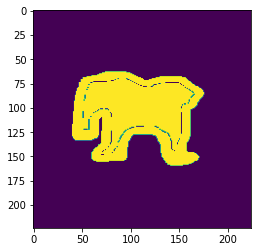

In [ ]:
#illustration the mask
plt.figure()
plt.imshow(label[0,:,:])

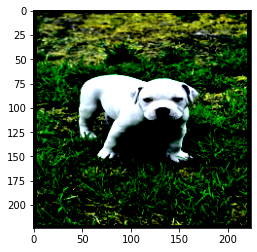

In [ ]:
#illustration the iamge
plt.figure()
plt.imshow(img.permute(1, 2, 0))

##Model

Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task. There are bunches of CNN models that are trained on a huge dataset for classification tasks, e.g., ResNet, [VGG19](https://arxiv.org/pdf/1409.1556.pdf), and so on. So, instead of training the model from scratch (starting from randomly initialized weights), we use VGG19 as the encoder part. This way, our model would converge faster, and a lot of computation and time would be saved. For the sake of time and size of the dataset, we use VGG16 as it is and do not train it, i.e., we freeze the encoder parameter during training.

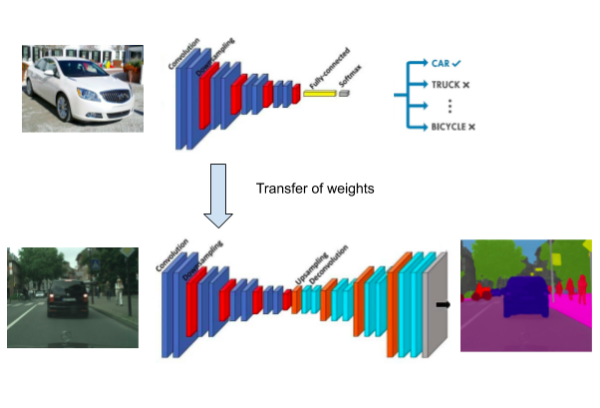

###Encoder

The architecture of VGG19 is shown in the image below. It contains a series of convolution layers with different sizes followed by two dense layers.

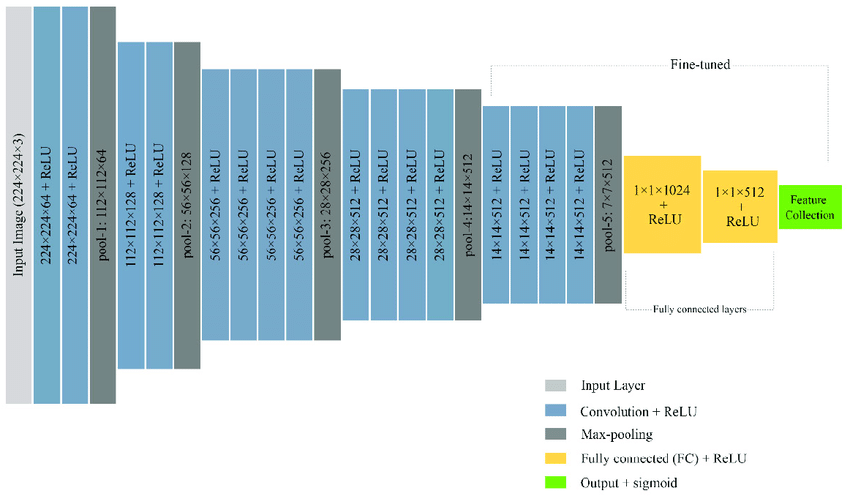

Using the cell below, load the VGG19 model.

In [ ]:
vgg19 = torchvision.models.vgg19(weights= 'DEFAULT')
vgg19

We only need the CNN part of the model. Complete the cell below to extract `vgg19` until the last max pool layer (without the max pool itself) and save it as your encoder.

In [ ]:
encoder =  vgg19.features[:-1]

###Decoder

As you can see encoder gets a $244\times244$ image and downsamples it to a $14\times14$ feature map through the multiple layers. We want our decoder to follow the pattern of the encoder but obviously in the reverse direction; namely, instead of the convolution layer (`Conv2d`) and max-pooling (`MaxPool2d`), we will use transposed convolution layer (`ConvTranspose2d`) and upsampling (`UpsamplingNearest2d`). You can see the desired architecture of the decoder in the image below.

(Use  ReLU as the activation function for `ConvTranspose2d` layers )

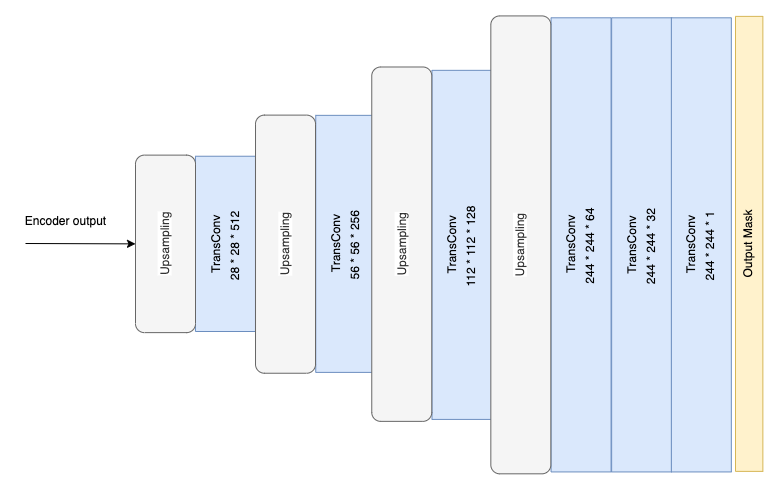

you can set:



*   `kernel_size` = 3
*   `stride` = 1
*   `padding` = 1
*   `output_padding` = 0

for  `ConvTranspose2d` layers.


Explain each of these items and how they affect the output.

<font color='red'>Answer Here</font>


---

`kernel_size` -> It is the window size of kernel that slide over pixels of input volumne(image) and used to extract features from group of pixels. The opposite of that in `ConvTranspose2d` is going to build a layer from a pooling layer.

`Stride` -> Stride is a parameter of the CNN filter that modifies the amount of movement over the image or video.

`padding` -> The amount of pixels added to an image when it is being processed by the kernel of a CNN.

`output_padding` -> controls the additional size added to one side of the output shape. The padding argument effectively adds `dilation * (kernel_size - 1) - padding` amount of zero padding to both sizes of the input. This is set so that when a `Conv2d` and a `ConvTranspose2d` are initialized with same parameters, they are inverses of each other in regard to the input and output shapes. However, when `stride > 1`, Conv2d maps multiple input shapes to the same output shape. `output_padding` is provided to resolve this ambiguity by effectively increasing the calculated output shape on one side. Note that `output_padding` is only used to find output shape, but does not actually add zero-padding to output.(according to Conv2dTranspose docs)



Each pixel of the output mask should show the probability that the corresponding pixel in the image belongs to the pet body (so, do not forget about sigmoid!).

In [ ]:
class Decoder(nn.Module):

    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.UpsamplingNearest2d(size=28),
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.ReLU(inplace=True),
            nn.UpsamplingNearest2d(size=56),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.ReLU(inplace=True),
            nn.UpsamplingNearest2d(size=112),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.ReLU(inplace=True),
            nn.UpsamplingNearest2d(size=224),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.features(x)

        return x


decoder = Decoder()

In [ ]:
class Segmentation(nn.Module):

    def __init__(self, enc, dec):
        super().__init__()

        self.seg = nn.Sequential(
            enc,
            dec,
            # nn.Sigmoid(inplace=True),
        )


    def forward(self, image):
        image = self.seg(image)

        return image

In [ ]:
model = Segmentation(encoder, decoder)

##Training

Since we want the encoder to be frozen during training, wirte a code to freeze the model encoder.

In [ ]:
#freeze the encoder of your model

# for para in model.parameters():
#     print(para)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)


In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad and '.0.' in name:
        param.requires_grad = False

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

seg.1.features.1.weight
seg.1.features.1.bias
seg.1.features.4.weight
seg.1.features.4.bias
seg.1.features.7.weight
seg.1.features.7.bias
seg.1.features.10.weight
seg.1.features.10.bias
seg.1.features.12.weight
seg.1.features.12.bias
seg.1.features.14.weight
seg.1.features.14.bias


Since it is a relatively computation-intensive task, please use GPU.

In [ ]:
#ToDo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

You can use these values for hyperparameters but feel free to change them.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 64
learning_rate = 5e-4
weight_decay=1e-05
epochs = 15


train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

use binary cross entropy for the loss and adam for the optimizer (you are always allowed to use the other correct options).

In [ ]:
optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
loss = nn.BCEWithLogitsLoss()

Complete the cell below to train your model. Train it for more than 10 epochs and at the end of each epoch report the loss value.

In [ ]:
from tqdm.notebook import tqdm  #you can use this to monitor training process

def train(model, loss_function, optimizer, train_loader, epochs):

    train_losses = []

    # Set the model to train mode
    model.train()

    # Training loop
    # tqdm_train_loader =

    for i in range(epochs):

        batch_train_losses = []

        for batch in tqdm(train_loader, desc=f'Epoch:{i+1}/{epochs}'):

            # correct = 0 # Correct prediction per batch

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            images = batch[0].to(device)
            labels = batch[1].to(device)

            ## Step 2: Run the model on the input data
            preds = model(images)
            preds = preds.squeeze(-1)

            ## Step 3: Calculate the loss
            loss = loss_function(preds, labels)

            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()

            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()

            # Train loss of each batch
            batch_train_losses.append(loss.item())


        train_losses.append(np.mean(batch_train_losses))
        print(f'loss: {train_losses[i]}')

    return train_losses

In [ ]:
train_losses = train(model, loss, optim, train_loader, epochs)

Epoch:1/15:   0%|          | 0/58 [00:00<?, ?it/s]

loss: 0.49407142863191406


Epoch:2/15:   0%|          | 0/58 [00:00<?, ?it/s]

loss: 0.49201664482725077


Epoch:3/15:   0%|          | 0/58 [00:00<?, ?it/s]

loss: 0.4905461386359971


Epoch:4/15:   0%|          | 0/58 [00:00<?, ?it/s]

loss: 0.48821795500557996


Epoch:5/15:   0%|          | 0/58 [00:00<?, ?it/s]

loss: 0.4865073525700076


Epoch:6/15:   0%|          | 0/58 [00:00<?, ?it/s]

loss: 0.48468310822700633


Epoch:7/15:   0%|          | 0/58 [00:00<?, ?it/s]

loss: 0.48323084825071794


Epoch:8/15:   0%|          | 0/58 [00:00<?, ?it/s]

loss: 0.48227652496305007


Epoch:9/15:   0%|          | 0/58 [00:00<?, ?it/s]

loss: 0.48121945559978485


Epoch:10/15:   0%|          | 0/58 [00:00<?, ?it/s]

loss: 0.4799801270509588


Epoch:11/15:   0%|          | 0/58 [00:00<?, ?it/s]

loss: 0.479796776997632


Epoch:12/15:   0%|          | 0/58 [00:00<?, ?it/s]

loss: 0.4785597601841236


Epoch:13/15:   0%|          | 0/58 [00:00<?, ?it/s]

loss: 0.47722897550155374


Epoch:14/15:   0%|          | 0/58 [00:00<?, ?it/s]

loss: 0.4773224638453845


Epoch:15/15:   0%|          | 0/58 [00:00<?, ?it/s]

loss: 0.47625855279379875


##Test

Now enjoy the result of your hard work!

In [ ]:
def thresholding_mask(mask, thr = 0.5):
    mask[mask < thr] = 0
    mask[mask >= thr] = 1
    return mask


In [ ]:
model.cpu()
mask = model(dataset_test[75][0].view(1,3, 224, 224))

In [ ]:
mask = thresholding_mask(mask)

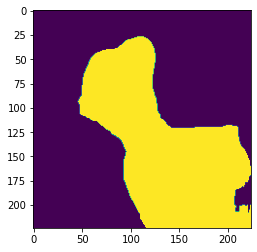

In [ ]:
plt.imshow(mask.detach()[0,0,:,:])

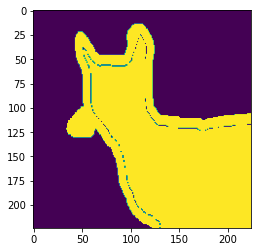

In [ ]:
plt.imshow(dataset_test[75][1][0,:,:])

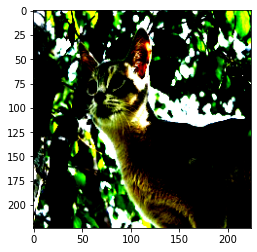

In [ ]:
plt.imshow(dataset_test[75][0].permute(1, 2, 0))

##Optional

Find a proper metric for the segmentation task and explain it. Use your metric to measure how well your model works on the test dataset.

#Part2: Sentiment Analyzing

Sentiment analysis is the task of classifying the polarity of a given text. For instance, a text-based tweet can be categorized into either "positive" or "negative". Given the text and accompanying labels, a model can be trained to predict the correct sentiment.

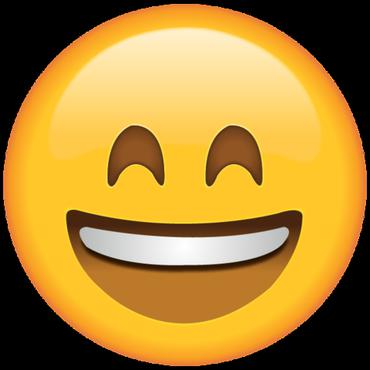

In this part, you will use a pre-trained model from the [huggingface](huggingface.co) and fine-tune it for the sentiment analyzing task using the provided dataset. Fine-tuning a pre-trained model is a common practice to build a model for downstream tasks in the NLP world!

All you need to know for this part is in this [link](https://huggingface.co/docs/transformers/training)!

## Prerequisites

In [ ]:
from google.colab import output

In [ ]:
!pip install datasets
!pip install transformers
output.clear()

In [ ]:
!pip install evaluate

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DefaultDataCollator
from datasets import load_dataset
import numpy as np
from datasets import load_metric
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate

##Dataset

The dataset for this part is [IMDB dataset](https://huggingface.co/datasets/imdb), a large movie review Dataset. It is a dataset for binary sentiment classification containing 25,000 highly polar movie reviews for training and 25,000 for testing.



Use the cell below to load the dataset from huggingface.

In [ ]:
imdb = load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
train_dataset = imdb["train"].shuffle(seed=42)
test_dataset = imdb["test"].shuffle(seed=42)

In [ ]:
print(train_dataset['text'][50])
print(train_dataset['label'][50])

When I was a kid, I totally loved both Bill & Ted Movies. The other night, Bogus Journey was on and since it was at least 5 years since I last saw it, I decided to tune in. AND I LOVED IT ALL OVER AGAIN! This film is still funny after all those years. 'Excellent Adventure' is better, but this one rocks just the same. Sure, some of the perfomances are a bit cheesy, but hey, this entire film is cheesy in a cool way. Plus it features the coolest personation of Death ever in a movie! Concluding: Totally like non bogus movie dude! Way Excellent! STATION!!!
1


In [ ]:
print(train_dataset['text'][100])
print(train_dataset['label'][100])

There is no artistic value in this movie to deserve any award. Well, it does not deserve an audience as well. Ironically, one of the awards is for cinematography but frankly, the camera movements are disconcerting to say the least. Every frame, you feel you are getting the "full picture", its like someone is "cropping your view" from the edges. The story is pathetic. Well, I will be honest, I could not bear to watch the entire movie. The part that sucked the most was when I saw the soldiers partying in their barracks and one of the soldiers coaxed to drink liquor. These and many other similar scenes reminded me so much of Steven Seagal.<br /><br />Take my advice, stay away from this piece of crap.
0


##Loading and Tokenizing

As the pre-trained model, we will use BERT (Bidirectional Encoder Representations from Transformers), one of the very first pre-trained models.

Load the tokenizer and model as described in the tutorial.

In [ ]:
check_point = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(check_point)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(check_point, num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

There is also another checkpoint called "bert-base-cased", study how these two checkpoints are different.

<font color='red'>Answer Here</font>


---

Both of them are pretrained models on english language using a masked language modeling objective. But, in BERT uncased, the text has been lowercased before WordPiece tokenization step while in BERT cased, the text is same as the input text (no changes).


Define the `pre-process` function and apply it to the train and test dataset to tokenize the samples.

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

Explain the `padding` and `truncation` inputs of the tokenizer.

<font color='red'>Answer Here</font>


---

> `padding` -> Sentences aren’t always the same length which can be an issue because tensors, the model inputs, need to have a uniform shape. Padding is a strategy for ensuring tensors are rectangular by adding a special padding token to shorter sentences.

> `truncation` -> Sometimes a sequence may be too long for a model to handle. In this case, you’ll need to truncate the sequence to a shorter length.

In [ ]:
print(tokenized_train_dataset[0]['text'])
print(tokenized_train_dataset[0]['label'])
print(tokenized_train_dataset[0]['input_ids'])
print(tokenized_train_dataset[0]['token_type_ids'])
print(tokenized_train_dataset[0]['attention_mask'])

There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier's plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it's the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...
1
[101, 2045, 2003, 2053, 7189, 2012, 2035, 2090, 3481, 3771, 1998, 6337, 2099, 2021, 1996, 2755, 2008, 2119, 2024, 2610, 2186, 2055, 6355, 6997, 1012, 6337, 2099, 3504, 15594, 2100, 1010, 3481, 3771, 3504, 4438, 1012, 6337, 2099, 14811, 202

See a sample of tokenized train dataset and answer these questions:



*   What is input-ids?
*   What is attention_mask?

please do not just copy or translate the huggingface sentences!



<font color='red'>Answer Here</font>


---

`input-ids` -> are the indices corresponding to each token in the sentence. They are numerical representations of tokens building sequences that will be used as input by the model.

```
sequence = "A Titan RTX has 24GB of VRAM"
tokenized_sequence = ['A', 'Titan', 'R', '##T', '##X', 'has', '24', '##GB', 'of', 'V', '##RA', '##M']
encoded_sequence = [101, 138, 18696, 155, 1942, 3190, 1144, 1572, 13745, 1104, 159, 9664, 2107, 102]
```

`attention_mask` -> indicates whether a token should be attended to or not. For example if set `padding=True` then `sequence_a` is going to padded and have longer length. The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them.

```
sequence_a = "This is a short sequence."
sequence_b = "This is a rather long sequence. It is at least longer than the sequence A."
```




##Training

Complete the function below to calculate the accuracy of your predictions. You will use this function to evalute the model on the test dataset during training.

In [ ]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return metric.compute(predictions=predictions, references=labels)

In [ ]:
data_collator = DefaultDataCollator()

For training, use huggingface `Trainer` API.
Apply the list below in the training process:


*   Train your model for 1000 steps
*   Evaluate your model for each 250 steps
*   At the end, load the checkpoint of the best model
*   Choose a proper batch size and learning rate



In [ ]:
training_args = TrainingArguments(output_dir="test_trainer",
                                  max_steps=1000,
                                  evaluation_strategy='steps',
                                  eval_steps=250,
                                  load_best_model_at_end=True,
                                  learning_rate=5e-5,
                                  per_device_train_batch_size=8,
                                  per_device_eval_batch_size=8,
                                  )

trainer = Trainer(
    model=sentiment_model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs


What does "step" indicate in the training process?

<font color='red'>Answer Here</font>


---

"Steps" has the same meaning as the "batches". For example, if we have 20 steps then number of our batches for model to run is 20.


Now train your model.

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 25000
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1000
  Number of trainable parameters = 109483778


Step,Training Loss,Validation Loss,Accuracy
250,No log,0.264327,0.903680
500,0.385700,0.256589,0.912600
750,0.385700,0.236513,0.920480
1000,0.286900,0.246578,0.922320


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 25000
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 25000
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If 

TrainOutput(global_step=1000, training_loss=0.33627914428710937, metrics={'train_runtime': 4090.7275, 'train_samples_per_second': 1.956, 'train_steps_per_second': 0.244, 'total_flos': 2104888442880000.0, 'train_loss': 0.33627914428710937, 'epoch': 0.32})

##Testing

Test your model on the sentence below.

In [ ]:
import torch
input = tokenizer('This movie disappointed me.')
sentiment_model.cpu()
sentiment_model(torch.tensor(input['input_ids']).view(1,-1))

SequenceClassifierOutput(loss=None, logits=tensor([[ 2.4323, -3.1159]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

Good Luck.